## Create a Haystack RAG pipeline using Amazon Bedrock - Part 1
---

Haystack is an open-source framework by deepset that allows developers to orchestrate LLM applications made up of different components like models, vector DBs, file converters, and countless other modules. Haystack provides pipelines and Agents, two powerful structures for designing LLM applications for various use cases including search, question answering, and conversational AI. With a big focus on state-of-the art retrieval methods and solid evaluation metrics, it provides you with everything you need to ship a reliable, trustworthy application. You can serialize pipelines to YAML files, expose them via a REST API, and scale them flexibly with your workloads, making it easy to move your application from a prototype stage to production.

In this notebook series, we will use Amazon Bedrock as a `DocumentTextEmbedder`, `TextEmbedder` and `Generator`. We will use the `amazon.titan-embed-text-v2:0` as our choice of embeddings model and `anthropic.claude-3-5-sonnet-20240620-v1:0` as our choice of generator model. 

In this notebook, we will do as follows:

1. Create a standard RAG pipeline on Haystack. We will use the `vblagoje/PubMedQA_instruction` dataset from where we will load documents in the InMemoryDataStore.

1. Embed the document and connect it to a writer, and write `1000` rows of this dataset to the `InMemoryDocumentStore` using `cosine` as the `embedding_similarity_function`

1. Create a RAG Anthropic Claude prompt template and use it in the prompt builder. We will also create an `AmazonBedrockGenerator` and use a `InMemoryBM25Retriever` as the retriever.

1. Lastly, we will connect all of these components into a single pipeline, serialize the pipeline and save it.

Once the pipeline is saved, we can load it in the next notebook and run inferences, and evaluate some of the responses.

In [1]:
# For each component, it is essential to know the names of the input and the output. There are several components for various steps
# of the generative AI pipeline that are provided out of the box. This includes components for document stores, embedders, prompt
# builders and generators. You can also build your own component.
!pip install -Uq pip
!pip install -Uq haystack
!pip install -Uq sentence-transformers
!pip install -Uq amazon-bedrock-haystack

In [2]:
# Install the Chroma integration, Haystack will come as a dependency
!pip install -U chroma-haystack "huggingface_hub>=0.22.0"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.2
    Uninstalling pydantic-2.9.2:
      Successfully uninstalled pydantic-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dspy 2.5.30 requires pydantic~=2.0, but you have pydantic 1.10.19 which is incompatible.


In [3]:
# Install all of the latest packages within DSPy using the following command
!pip install -Uq git+https://github.com/stanfordnlp/dspy.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastapi 0.95.2 requires pydantic!=1.7,!=1.7.1,!=1.7.2,!=1.7.3,!=1.8,!=1.8.1,<2.0.0,>=1.6.2, but you have pydantic 2.9.2 which is incompatible.


In [4]:
# import libraries
import os
# import dspy
import json
import boto3
import pickle
import logging
import tempfile
import globals as g
import pandas as pd
from globals import *
from haystack import Pipeline
from datasets import load_dataset
from haystack.dataclasses import Document
# from dspy.primitives.prediction import Prediction
from haystack.components.writers import DocumentWriter
from haystack.components.builders import PromptBuilder
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack_integrations.components.embedders.amazon_bedrock import (
    AmazonBedrockDocumentEmbedder,
    AmazonBedrockTextEmbedder,
)
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

In [5]:
# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [6]:
# initialize a haystack pipeline
pipeline = Pipeline()

# At this point, all we have done is initialized the pipeline. As we try to view some of the contents
# of the pipeline, we will see that the pipeline is empty. This is because we have not yet added any
# components to the pipeline. We will now add some components to the pipeline.
pipeline.show()

In [7]:
# This dataset contains information about instructions, context for that instruction, a response and the category, 
dataset = load_dataset("vblagoje/PubMedQA_instruction")

# Shuffle and select 1000 samples from the 'train' split
train_data = dataset['train'].shuffle(seed=42).select(range(NUM_ROWS))
df = pd.DataFrame(train_data)

# Save as CSV
os.makedirs(g.DATA_DIR, exist_ok=True)
csv_path = os.path.join(g.DATA_DIR, g.PUBMED_QA_CSV_FNAME)
df.to_csv(csv_path, index=False)
logger.info(f"Dataset saved to {csv_path}")
df.head()

[2024-11-16 13:08:48,815] p36636 {877774040.py:12} INFO - Dataset saved to data/PubMedQA_instruction.csv


,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa


In [8]:
# view the information on the dataset that is loaded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  1000 non-null   object
 1   context      1000 non-null   object
 2   response     1000 non-null   object
 3   category     1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


#### Load the `vblagoje/PubMedQA_instruction` dataset in the in-memory document store

Now, we will load the document to the in `InMemoryDocumentStore` using the `cosine` similarity function. We will use the `AmazonBedrockDocumentEmbedder` to embed the documents and then connect the embedder to the writer.

In [9]:
# Create an InMemoryDocumentStore with cosine similarity
# Run the pipeline with the documents from the DataFrame
chroma_persist_path = os.path.join(g.DATA_DIR, "chroma_store")
os.makedirs(chroma_persist_path, exist_ok=True)
document_store = ChromaDocumentStore(
    persist_path=chroma_persist_path,
    collection_name="documents",
    distance_function="cosine"
)

# Initialize the Bedrock document embedder with Titan model
document_embedder = AmazonBedrockDocumentEmbedder(
    model=g.TITAN_TEXT_EMBED_MODELID,
    aws_region=g.AWS_REGION # Specify your AWS region
)

# Add components to the pipeline
pipeline.add_component('embedder', document_embedder)
pipeline.add_component('writer', DocumentWriter(document_store))

# Connect the components
# The embedder will create embeddings that the writer will store
pipeline.connect('embedder.documents', 'writer.documents')


[2024-11-16 13:08:48,843] p36636 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


🚅 Components
  - embedder: AmazonBedrockDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

#### View the current status of the pipeline. At this point, we will see an embedder and a writer. The embedder takes in a list of documents as input, embeds them and the writer uses the DocumentWriter to write those documents

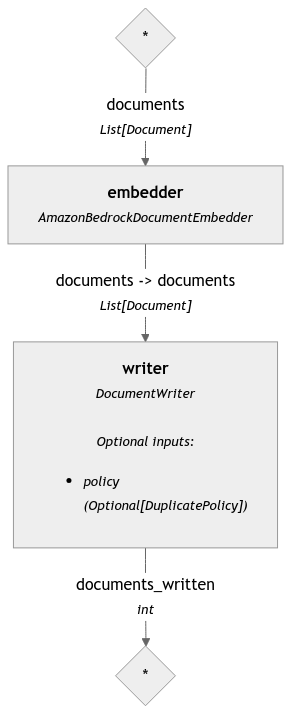

In [10]:
pipeline.show()

### Write the documents to the document store using `pipeline.run` on the `embedder`

Now, we will write the documents using the embedder.

In [11]:
# Load the dataset
df = pd.read_csv(csv_path) 

# Prepare documents
documents = []
for _, row in df.iterrows():
    doc = Document(
        content=f"Instruction: {row['instruction']}\nContext: {row['context']}\nResponse: {row['response']}",
        meta={
            "category": row["category"],
            "question": row["instruction"]
        }
    )
    documents.append(doc)

# Run the pipeline with documents
pipeline.run({
    "embedder": {
        "documents": documents
    }
})

[2024-11-16 13:08:49,089] p36636 {pipeline.py:75} INFO - Running component embedder
Creating embeddings: 100%|██████████| 1000/1000 [01:58<00:00,  8.41it/s]
[2024-11-16 13:10:48,158] p36636 {pipeline.py:75} INFO - Running component writer
[2024-11-16 13:10:48,160] p36636 {posthog.py:22} INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
[2024-11-16 13:10:48,260] p36636 {sqlite.py:297} WARNING - Insert of existing embedding ID: b0ed113f8aeaf4a32eb471ce17662234549b3878a4d46a09a95707eb08a00948
[2024-11-16 13:10:48,261] p36636 {local_persistent_hnsw.py:339} WARNING - Add of existing embedding ID: b0ed113f8aeaf4a32eb471ce17662234549b3878a4d46a09a95707eb08a00948
[2024-11-16 13:10:48,264] p36636 {sqlite.py:297} WARNING - Insert of existing embedding ID: bcc4a7a5fd909de875f401e32b6a6c218fecad204d366f1eae11f28eb50bad5b
[2024-11-16 13:10:48,264] p36636 {local_persistent_hnsw.py:339} WARNING - Add of existing embedding ID: bcc4a

{'writer': {'documents_written': 1000}}

In [12]:
print(f"Added {len(documents)} documents to the document store.")

Added 1000 documents to the document store.


### Create the haystack pipeline
---

### RAG Pipeline Implementation with Haystack and Amazon Bedrock
 
1. Generator Initialization: Initialize Amazon Bedrock generator for response generation
- Uses specified Bedrock model ID
- Handles the inference/completion step in the RAG pipeline

2. Retriever Setup: Initialize ChromaQueryTextRetriever retriever with in-memory document store
- Uses BM25 algorithm for document similarity scoring
- top_k=3 retrieves the 3 most relevant documents

3. Define Jinja2 template for structuring the prompt

```
<result>
{% for document in documents %}
    {{ document.content }}
{% endfor %}

To answer the question "{{question}}":
[Provide a concise answer to the question based on the given context. Include relevant details and figures as needed, but avoid unnecessary elaboration or tangents.]
</result>
```

At the end, we connect the components together and create a fully functioning haystack pipeline using Amazon Bedrock.


In [13]:
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever

# Initialize the amazon bedrock generator that is used to generate responses to questions
# at the inference step of the RAG pipeline
generator = AmazonBedrockGenerator(model=g.BEDROCK_HAIKU_MODELID)

# initialize the retriever
retriever = ChromaQueryTextRetriever(document_store)

# Haystack uses jinja template formatting
template = """
<result>
{% for document in documents %}
    {{ document.content }}
{% endfor %}

To answer the question "{{question}}":
[Provide a concise answer to the question based on the given context. Include relevant details and figures as needed, but avoid unnecessary elaboration or tangents.]
</result>
"""

# Build the prompt and add other components to the RAG
# pipeline
prompt_builder = PromptBuilder(template=template)
rag_pipeline = Pipeline()
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

[2024-11-16 13:10:52,863] p36636 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


🚅 Components
  - retriever: ChromaQueryTextRetriever
  - prompt_builder: PromptBuilder
  - llm: AmazonBedrockGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

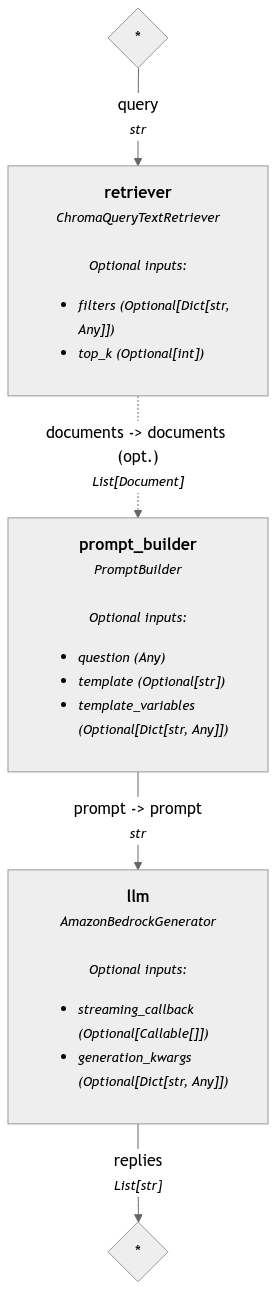

In [14]:
# view the pipeline. At this point, you should be able to see the pipeline
# graph, which shows the steps in the pipeline and the dependencies between them.
rag_pipeline.show()

In [15]:
retriever = rag_pipeline.get_component("retriever")
document_store = retriever.document_store
doc_count = len(document_store.filter_documents())
print(f"Number of documents in store: {doc_count}")

Number of documents in store: 1000


### Save the haystack pipeline
---

Now, before running inferences, we will save the pipeline and upload it to s3 for later use. This haystack pipeline is saved as a `yml` file within s3, as given below:

![haystack_yml](/images/yml_example.png)

In [16]:
# Create temporary file and save pipeline
with tempfile.NamedTemporaryFile(mode='w', suffix='.yml', delete=False) as tmp_file:
    print(f"Saving pipeline to {tmp_file.name}")
    rag_pipeline.dump(tmp_file)
    print(f"Saved pipeline to {tmp_file.name}")
    tmp_file_path = tmp_file.name

Saving pipeline to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmptx_6hyi_.yml
Saved pipeline to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmptx_6hyi_.yml


In [17]:
import shutil
from io import BytesIO

# Initialize S3 client
s3_client = boto3.client('s3')

# Upload pipeline to S3
with open(tmp_file_path, 'rb') as file:
    s3_client.upload_fileobj(
        file, 
        g.HAYSTACK_PIPELINE_BUCKET, 
        g.HAYSTACK_PIPELINE_KEY
    )
    print(f"Uploaded pipeline to {g.HAYSTACK_PIPELINE_BUCKET}/{g.HAYSTACK_PIPELINE_KEY}")

[2024-11-16 13:10:53,698] p36636 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


Uploaded pipeline to sagemaker-us-east-2-015469603702/pipelines/basic_rag_pipeline.yml


In [18]:
import shutil

# Create a zip file of the chroma store directory
chroma_zip_path = os.path.join(g.DATA_DIR, 'chroma_store.zip')
os.makedirs(os.path.dirname(chroma_zip_path), exist_ok=True)
shutil.make_archive(
    os.path.join(g.DATA_DIR, 'chroma_store'),
    'zip',
    chroma_persist_path
)

# Upload the zipped chroma store to S3
with open(chroma_zip_path, 'rb') as file:
    s3_client.upload_fileobj(
        file, 
        g.HAYSTACK_PIPELINE_BUCKET, 
        g.CHROMA_DOC_STORE_KEY
    )
    print(f"Uploaded document store to {g.HAYSTACK_PIPELINE_BUCKET}/{g.CHROMA_DOC_STORE_KEY}")

# Clean up the zip file
os.remove(chroma_zip_path)

Uploaded document store to sagemaker-us-east-2-015469603702/pipelines/document_store/chroma_store.zip


In [19]:
os.remove(tmp_file_path)
print(f"Removed the tmp file path containing the pipeline.")

Removed the tmp file path containing the pipeline.


Now that we have uploaded the haystack pipeline to s3, you can use it in a lambda function for example to serve it as an endpoint. For this you would have to create a lambda function, and in the lambda code:

1. Load the pipeline from the s3 location, use it for incoming requests.

1. Create an API gateway that triggers the function and passes in the user input that goes into the RAG pipeline.